# 一個Gaussian 跑 SDE, ODE - Forward and Backward

In [3]:
import numpy as np

def m_t(t, mu1, beta):
    return np.exp(-beta*t) * mu1

def v_t(t, s1, beta, sigma):
    return np.exp(-2*beta*t) * s1**2 + (sigma**2/(2*beta)) * (1.0 - np.exp(-2*beta*t))

def gmm_pdf(y, mu1, s1):
    # p_0(x)
    y = np.asarray(y)
    return (1.0 / (np.sqrt(2*np.pi) * s1)) * np.exp(-0.5 * ((y - mu1) / s1)**2)

def gmm_ou_pdf(y, t, mu1, s1, beta, sigma):
    # p_t(x) after OU
    y = np.asarray(y)
    m  = m_t(t, mu1, beta)
    v  = v_t(t, s1, beta, sigma)
    return (1.0 / np.sqrt(2*np.pi * v)) * np.exp(-0.5 * (y - m)**2 / v)

def gmm_ou_score(x, t, mu1, s1, beta, sigma):
    # ∇_x log p_t(x) = -(x - m_t)/v_t
    x = np.asarray(x)
    m = m_t(t, mu1, beta)
    v = v_t(t, s1, beta, sigma)
    return -(x - m) / v


In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot(traj_hist, times, t_target, mu1, s1, beta, sigma):
    fig = plt.figure(figsize=(11,2.2))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
    ax_left  = fig.add_subplot(gs[0,0])
    ax_main  = fig.add_subplot(gs[0,1])
    ax_right = fig.add_subplot(gs[0,2])

    # 中間：軌跡
    for j in range(traj_hist.shape[1]):
        ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
    ax_main.set_xlabel("$t$")

    ymin = np.min(traj_hist); ymax = np.max(traj_hist)
    pad = 0.2*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(*ylims)
    ys = np.linspace(*ylims, 700)

    # 左： p0(x)
    ax_left.plot(gmm_pdf(ys, mu1, s1), ys, color="C0", linewidth=2)
    ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

    # 右： p_T(x) 
    T_end = float(times[-1])
    ax_right.plot(gmm_ou_pdf(ys, T_end, mu1, s1, beta, sigma), ys,
                  color="C0", linewidth=2)
    ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

    # t_target 的 density 疊在軌跡上
    pdf_mid = gmm_ou_pdf(ys, t_target, mu1, s1, beta, sigma)
    scale = 0.25
    pdf_mid_norm = pdf_mid / pdf_mid.max()
    ax_main.plot(t_target + scale*pdf_mid_norm, ys, color="C0", linewidth=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)

    plt.show()


## 1. Forward SDE

In [5]:
def SDE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part):
    steps = int(T/dt)

    # 初始：從 p0 取樣
    x = rng.normal(mu1, s1, size=N_part)

    times = [0.0]
    traj_hist = [x[:K_traj].copy()]
    t = 0.0

    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        x = x + (-beta*x)*dt + sigma*dW
        t += dt

        if i % max(1, int(steps/300)) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    plot(traj_hist, times, t_target, mu1, s1, beta, sigma)


In [6]:
beta=0.7
sigma=1.0
T=20.0
t_target=10.0
dt=5e-3  #時間步長

mu1=8.0
s1=2.0

K_traj=10  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

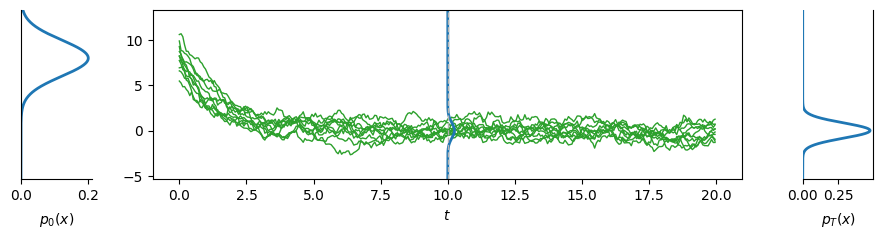

In [7]:
SDE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)

# 2. Backward SDE

In [8]:
def SDE_reverse(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part):
    rng = np.random.default_rng(40)

    steps = int(T/dt)

    # ---- 你給的這三行：t = T 時 OU 的解析分布 ----
    mean_T = np.exp(-beta*T)*mu1
    sigma_T_square = np.exp(-2.0*beta*T)*(s1**2) \
                     + (1-np.exp(-2.0*beta*T))*(sigma**2)/(2.0*beta)
    sigma_T = np.sqrt(sigma_T_square)

    # 從 p_T 抽樣當作反向 SDE 的起點
    x = rng.normal(mean_T, sigma_T, size=N_part)

    times = [T]
    traj_hist = [x[:K_traj].copy()]
    t = T

    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)

        # score = ∇_x log p_t(x)
        score = gmm_ou_score(x, t, mu1, s1, beta, sigma)
        # 因為是OU 有解析解 所以直接有score function
        # 非OU才要用ML學

        # Reverse drift（Anderson / Song）
        drift = -beta*x - sigma**2 * score

        # 時間往後退：dt > 0，但這邊是 t -= dt，所以乘上 -dt
        x = x + drift * (-dt) + sigma * dW

        t -= dt

        if i % max(1, int(steps/300)) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    # ---- 把時間排序成 0 → T，再畫圖 ----
    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    idx = np.argsort(times)
    times = times[idx]
    traj_hist = traj_hist[idx]

    plot(traj_hist, times, t_target, mu1, s1, beta, sigma)


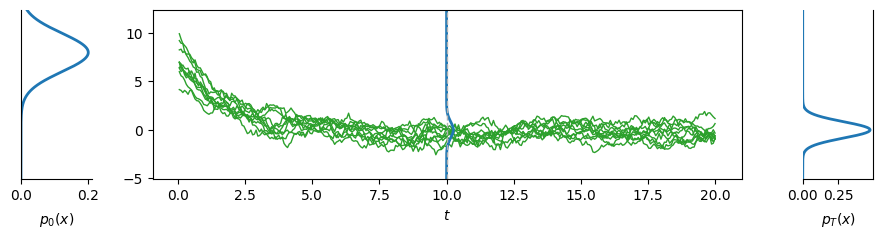

In [9]:
SDE_reverse(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)

# 3. Forward ODE

In [10]:
def ODE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part):
    rng = np.random.default_rng(42)

    steps = int(T/dt)

    # 初始：x_0 ~ N(mu1, s1^2)
    x = rng.normal(mu1, s1, size=N_part)

    times = [0.0]
    traj_hist = [x[:K_traj].copy()]
    t = 0.0

    for i in range(1, steps+1):
        t += dt

        # score at time t
        score = gmm_ou_score(x, t, mu1, s1, beta, sigma)

        # Probability flow ODE: dx/dt = f - 1/2 g^2 score
        drift = -beta * x - 0.5 * (sigma**2) * score

        # Euler step (no noise term)
        x = x + drift * dt

        if i % max(1, int(steps/300)) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    plot(traj_hist, times, t_target, mu1, s1, beta, sigma)


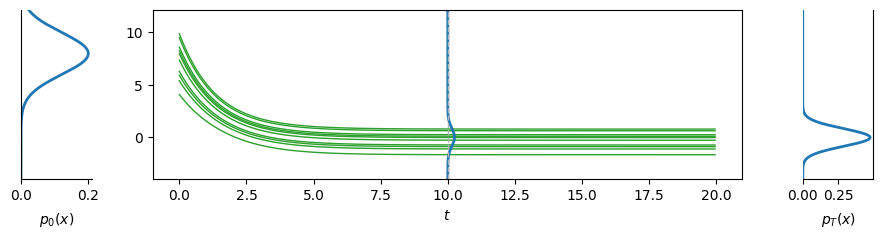

In [11]:
ODE_forward(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)

# 4. Backward ODE

In [12]:
def ODE_backward(beta, sigma, rng,
                 T, t_target, dt,
                 mu1, s1,
                 K_traj, N_part):
    rng = np.random.default_rng(512)

    steps = int(T/dt)

    # ---- t = T 時的 OU 解析分布：N(mean_T, sigma_T^2) ----
    mean_T = np.exp(-beta*T) * mu1
    var_T  = np.exp(-2.0*beta*T)*(s1**2) \
             + (1-np.exp(-2.0*beta*T))*(sigma**2)/(2.0*beta)
    sigma_T = np.sqrt(var_T)

    # 從 p_T 取樣當作 Backward ODE 的起點
    x = rng.normal(mean_T, sigma_T, size=N_part)

    times = [T]
    traj_hist = [x[:K_traj].copy()]
    t = T

    for i in range(1, steps+1):
        # score at current physical time t
        score = gmm_ou_score(x, t, mu1, s1, beta, sigma)

        # PF-ODE drift: f_PF(x,t) = -beta*x - 0.5*sigma^2 * score
        drift_pf = -beta * x - 0.5 * (sigma**2) * score

        # 時間往回走：t -> t - dt
        x = x + drift_pf * (-dt)
        t -= dt

        if i % max(1, int(steps/300)) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    # ---- 排成 0 → T，方便畫圖 ----
    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    idx = np.argsort(times)
    times = times[idx]
    traj_hist = traj_hist[idx]

    plot(traj_hist, times, t_target, mu1, s1, beta, sigma)


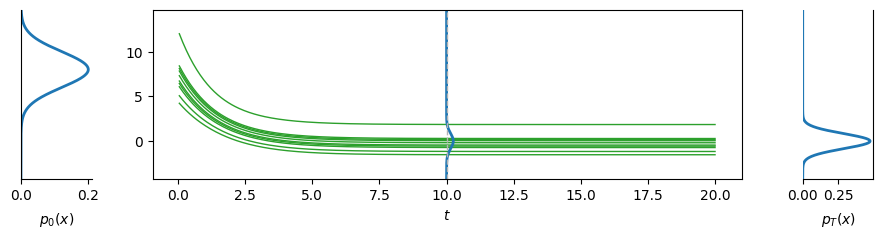

In [13]:
ODE_backward(beta, sigma, rng,
                 T, t_target, dt,
                 mu1, s1,
                 K_traj, N_part)